TODO:

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
import seaborn as sns
from tqdm.notebook import tqdm
from tqdm import trange

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import datasets, transforms
from torchvision.datasets import FashionMNIST

from boring_utils.utils import *

%matplotlib inline 
init_graph()
device = get_device()
set_seed(42, strict=True)

In [2]:
DATASET_PATH = "../data"
CHECKPOINT_PATH = "../model/optm_func/"
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

In [3]:
# https://pytorch.org/vision/main/generated/torchvision.transforms.Normalize.html
# transforms.Normalize(mean, std)
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,))
])

transform_b = transforms.Compose([
                transforms.ToTensor(),
])

train_set = FashionMNIST(
    root=DATASET_PATH, 
    train=True, 
    download=True, 
    transform=transform
)

test_set = FashionMNIST(
    root=DATASET_PATH, 
    train=False, 
    download=True, 
    transform=transform
)

train_set, val_set = torch.utils.data.random_split(train_set, [50000, 10000])

train_loader = DataLoader(
    train_set, batch_size=1024, shuffle=True, drop_last=False)

val_loader = DataLoader(
    val_set, batch_size=1024, shuffle=True, drop_last=False)

test_loader = DataLoader(
    test_set, batch_size=1024, shuffle=True, drop_last=False)

In [4]:
test_set_no_trans = FashionMNIST(
    root=DATASET_PATH, 
    train=False, 
    download=True, 
    transform=transform_b
)

test_loader_no_trans = DataLoader(
    test_set_no_trans, batch_size=1024, shuffle=True, drop_last=False)

Batch Preview

In [5]:
def print_data(dataset, data_loader):
    # raw data, untransformed
    cprint((dataset.data.float() / 255.0).mean().item())
    cprint((dataset.data.float() / 255.0).std().item())

    # transformed data
    imgs, _ = next(iter(data_loader))
    cprint(imgs.mean().item(), imgs.std().item())
    cprint(imgs.max().item(), imgs.min().item())

In [6]:
print_data(test_set, test_loader)

print_data -> (dataset.data.float() / 255.0).mean().item():
0.2868492901325226
print_data -> (dataset.data.float() / 255.0).std().item():
0.3524441719055176
print_data -> imgs.mean().item():
-0.42312583327293396
print_data -> imgs.std().item():
0.7069889307022095
print_data -> imgs.max().item():
1.0
print_data -> imgs.min().item():
-1.0


In [7]:
print_data(test_set_no_trans, test_loader_no_trans)

print_data -> (dataset.data.float() / 255.0).mean().item():
0.2868492901325226
print_data -> (dataset.data.float() / 255.0).std().item():
0.3524441719055176
print_data -> imgs.mean().item():
0.2812195122241974
print_data -> imgs.std().item():
0.34957683086395264
print_data -> imgs.max().item():
1.0
print_data -> imgs.min().item():
0.0


Define activation functions

In [8]:
act_fn_by_name = {}

class Tanh(nn.Module):
    '''
    https://pytorch.org/docs/master/generated/torch.nn.Tanh.html#torch.nn.Tanh
    '''
    def forward(self, x):
        return (torch.exp(x) - torch.exp(-x)) / (torch.exp(x) + torch.exp(-x))

act_fn_by_name['tanh'] = Tanh


class ReLU(nn.Module):
    '''
    https://pytorch.org/docs/master/generated/torch.nn.ReLU.html#torch.nn.ReLU
    '''
    def forward(self, x):
        # return torch.max(0, x)
        return x * (x > 0).float()

act_fn_by_name['relu'] = ReLU


class LeakyReLU(nn.Module):
    '''
    https://pytorch.org/docs/master/generated/torch.nn.LeakyReLU.html#torch.nn.LeakyReLU
    '''
    def __init__(self, negative_slope=0.1):
        super().__init__()
        self.neg_slop = negative_slope
        
    def forward(self, x):
        return torch.where(x > 0, x, self.neg_slop * x)

act_fn_by_name['leakyrelu'] = LeakyReLU


class Identity(nn.Module):
    def forward(self, x):
        return x

act_fn_by_name['identity'] = Identity

# Plot Functions

## vis grad

In [9]:
# from t3
def vis_gradients(
        net, color="C0", print_variance=False, 
        small_loader = DataLoader(train_set, batch_size=256, shuffle=False)
    ):
    """
    Inputs:
        net - Object of class BaseNetwork
        color - Color in which we want to visualize the histogram (for easier separation of activation functions)
    
    Use cross entropy loss for the first batch of the training set to calculate the gradients of the weights.
    """
    
    net.eval()
    imgs, labels = next(iter(small_loader))
    imgs, labels = imgs.to(device), labels.to(device)
    
    # Pass one batch through the network, and calculate the gradients for the weights
    net.zero_grad()
    preds = net(imgs)
    loss = F.cross_entropy(preds, labels)
    loss.backward()
    # We limit our visualization to the weight parameters and exclude the bias to reduce the number of plots
    grads = {name: params.grad.data.view(-1).cpu().clone().numpy() for name, params in net.named_parameters() if "weight" in name}
    net.zero_grad()
    
    # Plotting
    columns = len(grads)
    fig, ax = plt.subplots(1, columns, figsize=(columns*3.5, 2.5))
    fig_index = 0
    for key in grads:
        key_ax = ax[fig_index % columns]
        sns.histplot(
            data=grads[key], bins=30, ax=key_ax, color=color, kde=True)
        key_ax.set_title(str(key), fontsize=16)
        key_ax.set_xlabel("Grad magnitude")
        # key_ax.set_xticklabels(key_ax.get_xticklabels(), rotation=30)
        fig_index += 1

    fig.suptitle(f"Grad magnitude dist for act func {net.act_fn}", fontsize=24, y=1.2)
    fig.subplots_adjust(wspace=0.8)
    plt.show()
    plt.close() 

    if print_variance:
        for key in sorted(grads.keys()):
            print(f"{key} - Variance: {np.var(grads[key])}")


## plot dist from val_dict

In [10]:
def plot_dists(val_dict, color="C0", xlabel=None, stat="count", use_kde=True):
    columns = len(val_dict)
    fig, ax = plt.subplots(1, columns, figsize=(columns*3.5, 2.5))

    fig_index = 0  # used for fig label
    for key in sorted(val_dict.keys()):
        key_ax = ax[fig_index % columns]

        # Only plot kde if there is variance
        sns.histplot(
            val_dict[key], 
            ax=key_ax, 
            color=color, 
            bins=50, 
            stat=stat,
            kde=use_kde and (
                (val_dict[key].max() - val_dict[key].min()
            ) > 1e-8)
        ) 

        key_ax.set_title(
            f"{key} " + (r"(%i $\to$ %i)" % (val_dict[key].shape[1], val_dict[key].shape[0]) \
                if len(val_dict[key].shape) > 1 else ""), fontsize=16)

        if xlabel is not None:
            key_ax.set_xlabel(xlabel)
            
        fig_index += 1

    fig.subplots_adjust(wspace=0.8)
    return fig

## vis act

In [11]:
def vis_activations(
        model, color="C0", print_variance=False, 
        small_loader=DataLoader(train_set, batch_size=1024, shuffle=False)
    ):
    '''
    Pass one batch through the network (manually forward pass)
    and keep track of the activations at each layer
    and calculate the gradients for the weights
    '''
    model.eval()
    imgs, labels = next(iter(small_loader))
    imgs, labels = imgs.to(device), labels.to(device)
    
    feats = imgs.view(imgs.shape[0], -1)
    activations = {}
    with torch.no_grad():
        for layer_index, layer in enumerate(model.layers):
            feats = layer(feats)
            if isinstance(layer, nn.Linear):
                activations[f"Layer {layer_index}"] = \
                    feats.view(-1).detach().cpu().numpy()
    
    # Plotting
    fig = plot_dists(activations, color=color, stat="density", xlabel="Activation vals")
    fig.suptitle("Activation distribution", fontsize=24, y=1.2)
    plt.show()
    plt.close() 
    
    if print_variance:
        for key in sorted(activations.keys()):
            print(f"{key} - Variance: {np.var(activations[key])}")


## vis weigt dist

In [12]:
def vis_weight_distribution(model, color="C0"):
    '''
    weitghts is easier, directly use the model
    '''
    weights = {}
    for name, param in model.named_parameters():
        if name.endswith(".bias"):
            continue
        key_name = f"Layer {name.split('.')[1]}"
        weights[key_name] = param.detach().view(-1).cpu().numpy()
    
    # Plotting
    fig = plot_dists(weights, color=color, xlabel="Weight vals")
    fig.suptitle("Weight distribution", fontsize=24, y=1.2)
    plt.show()
    plt.close() 

# NN

In [13]:
class BaseNN(nn.Module):
    def __init__(self, act_fn, input_size=784, hidden_sizes=[512, 256, 256, 128], num_classes=10):
        super().__init__()
        
        self.act_fn = act_fn
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.num_classes = num_classes

        # Create the network based on the specified hidden sizes
        layers = []
        layer_sizes = [input_size] + hidden_sizes
        for layer_index in range(1, len(layer_sizes)):
            layers += [
                nn.Linear(layer_sizes[layer_index-1], 
                          layer_sizes[layer_index]),
                self.act_fn
                ]
        layers += [nn.Linear(layer_sizes[-1], num_classes)]
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        # reshape img to flat tensor
        # x = x.view(x.size(0), -1)
        x = x.view(-1, self.input_size)
        x = self.layers(x)
        return x
        


# [1] Constant Value Init

When initializing a neural network, there are a few properties we would like to have. 
- First, the variance of the input should be propagated through the model to the last layer, so that we have a similar standard deviation for the output neurons. If the variance would vanish the deeper we go in our model, it becomes much harder to optimize the model as the input to the next layer is basically a single constant value. Similarly, if the variance increases, it is likely to explode (i.e. head to infinity) the deeper we design our model. 
- The second property we look out for in initialization techniques is a gradient distribution with equal variance across layers. If the first layer receives much smaller gradients than the last layer, we will have difficulties in choosing an appropriate learning rate. 

As a starting point for finding a good method, we will analyze different initialization based on our linear neural network with no activation function (i.e. an identity). We do this because initializations depend on the specific activation function used in the network, and we can adjust the initialization schemes later on for our specific choice.

In [15]:
model = BaseNN(act_fn=Identity()).to(device)

## Init NN with a very close to 0 value (0.005)

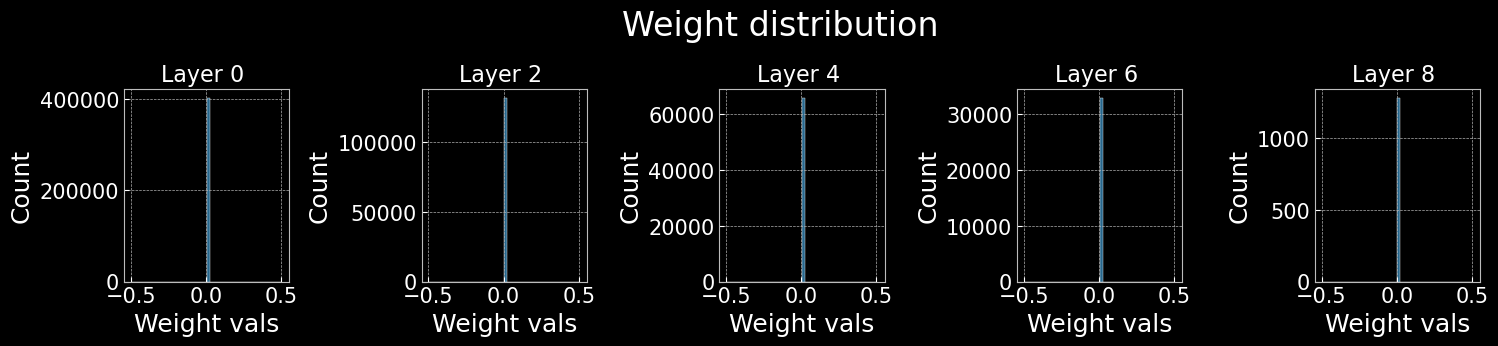

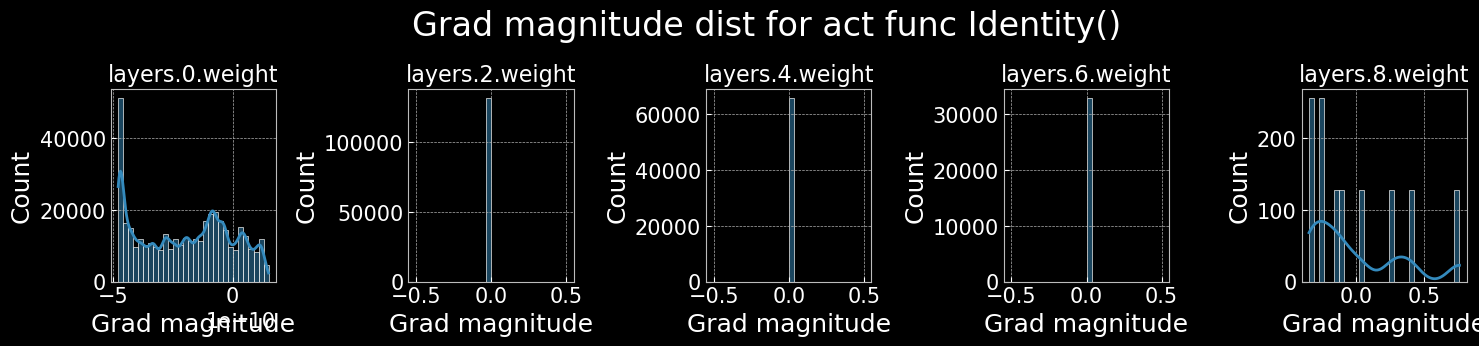

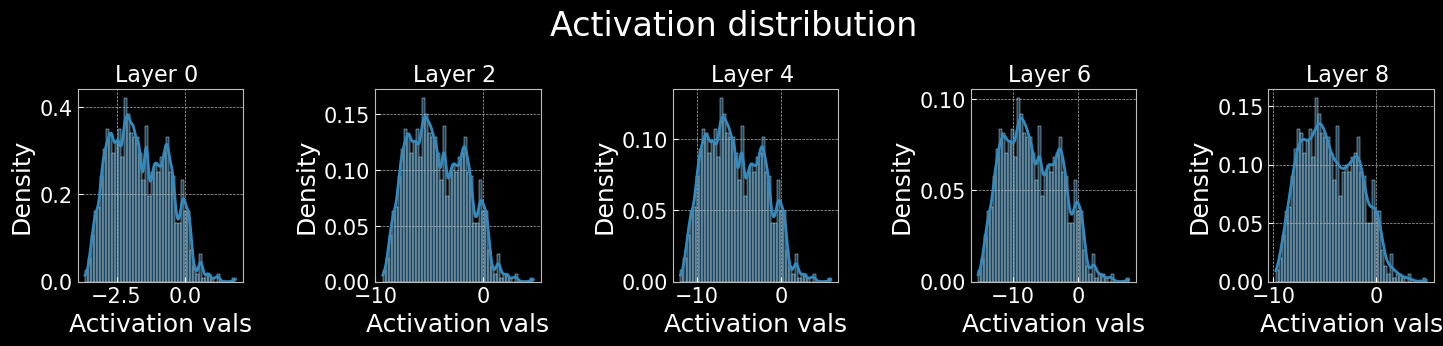

Layer 0 - Variance: 1.0259183645248413
Layer 2 - Variance: 6.723458290100098
Layer 4 - Variance: 11.015713691711426
Layer 6 - Variance: 18.04814338684082
Layer 8 - Variance: 7.392518520355225


In [27]:
def const_init(model, c=0.0):
    for name, param in model.named_parameters():
        param.data.fill_(c)

const_init(model, c=0.005)
vis_weight_distribution(model)
vis_gradients(model)
vis_activations(model, print_variance=True)

As we can see, only the first and the last layer have diverse gradient distributions while the other three layers have the same gradient for all weights (note that this value is unequal 0, but often very close to it). 

**Having the same gradient for parameters that have been initialized with the same values means that we will always have the same value for those parameters. This would make our layer useless and reduce our effective number of parameters to 1. Thus, we cannot use a constant initialization to train our networks.**

## Init NN with 0

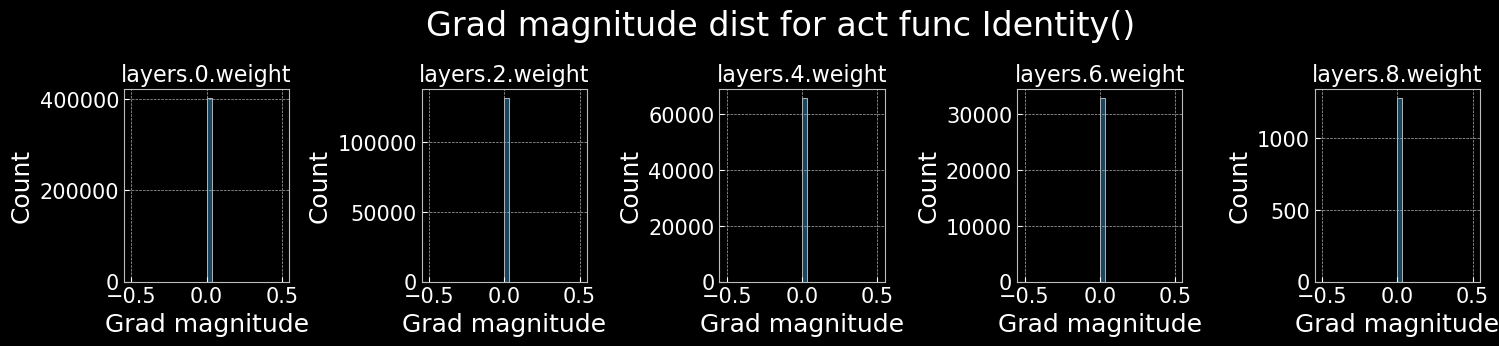

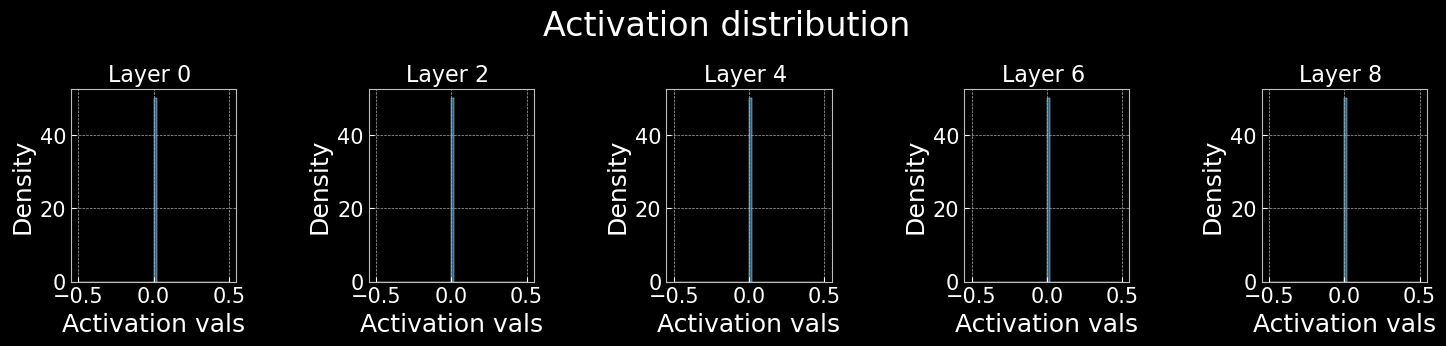

Layer 0 - Variance: 0.0
Layer 2 - Variance: 0.0
Layer 4 - Variance: 0.0
Layer 6 - Variance: 0.0
Layer 8 - Variance: 0.0


In [20]:
# extra: init all zero
const_init(model, c=0.)
# vis_weight_distribution(model)
vis_gradients(model)
vis_activations(model, print_variance=True)

# [2] Constant Var Init

From the experiment above, we have seen that a constant value is not working. So instead, how about we initialize the parameters by randomly sampling from a distribution like a Gaussian? The most intuitive way would be to choose one variance that is used for all layers in the network. Let's implement it below, and visualize the activation distribution across layers.

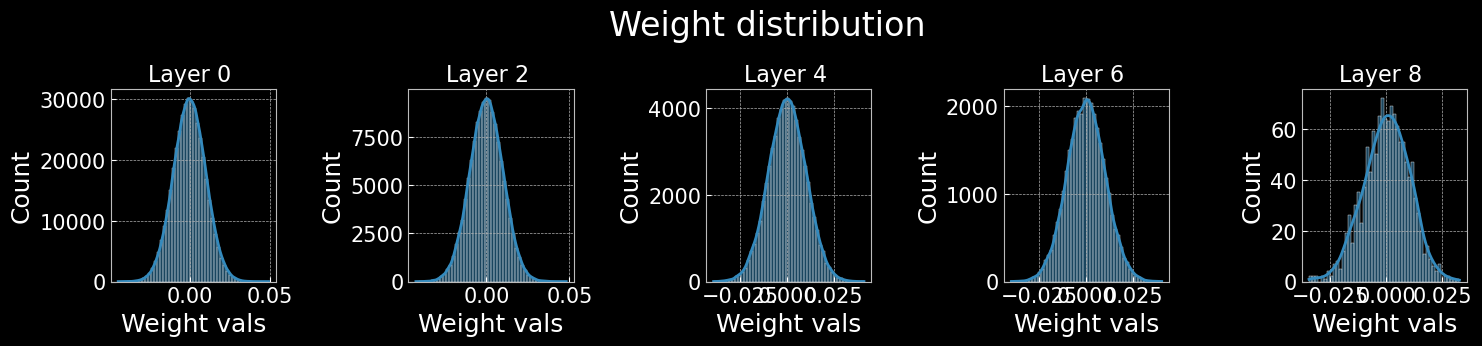

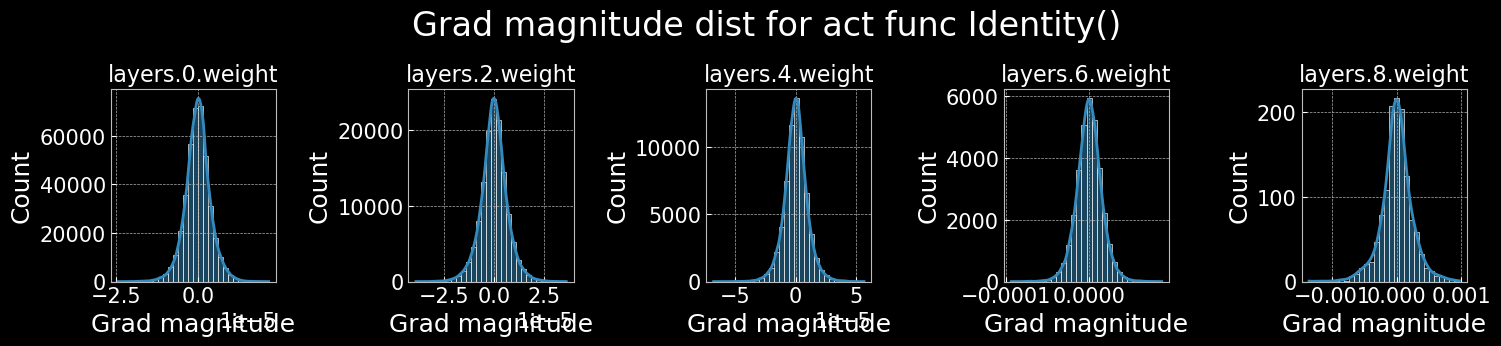

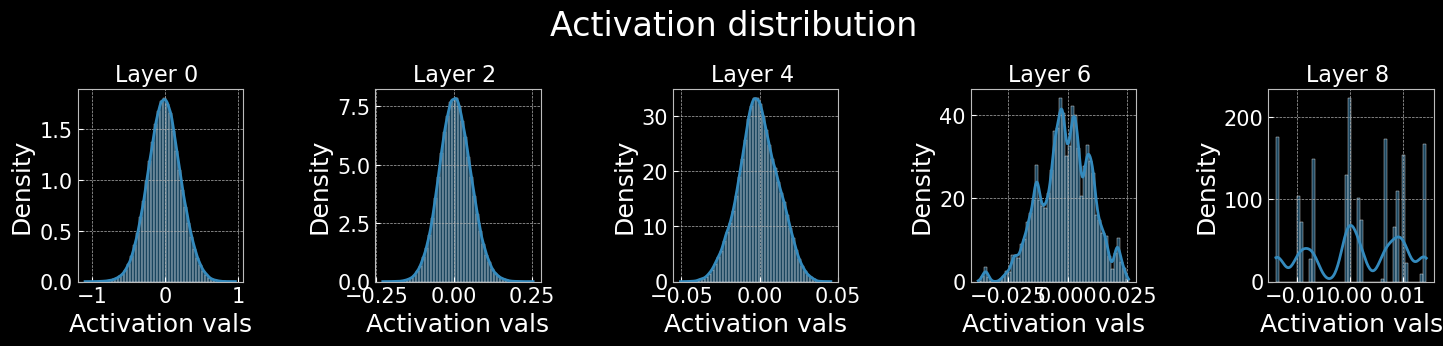

Layer 0 - Variance: 0.05155658349394798
Layer 2 - Variance: 0.002616654150187969
Layer 4 - Variance: 0.0001582531986059621
Layer 6 - Variance: 0.00011551562784006819
Layer 8 - Variance: 7.457812171196565e-05


In [28]:
def var_init(model, std=0.01):
    for name, param in model.named_parameters():
        param.data.normal_(std=std)

var_init(model, std=0.01)
vis_weight_distribution(model)  # our focus is var init, weights is data.normal_
vis_gradients(model)
vis_activations(model, print_variance=True)

**The variance of the activation becomes smaller and smaller across layers, and almost vanishes in the last layer.** Alternatively, we could use a higher standard deviation:

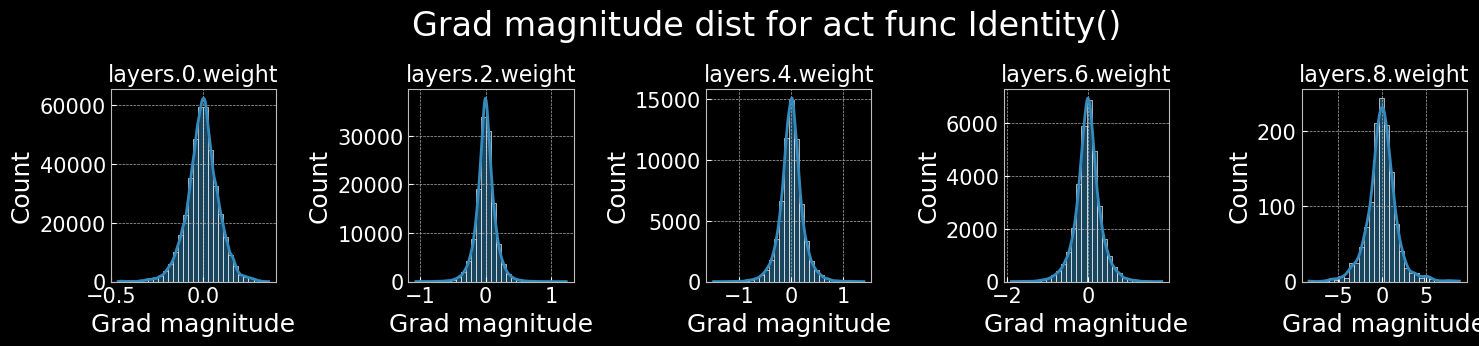

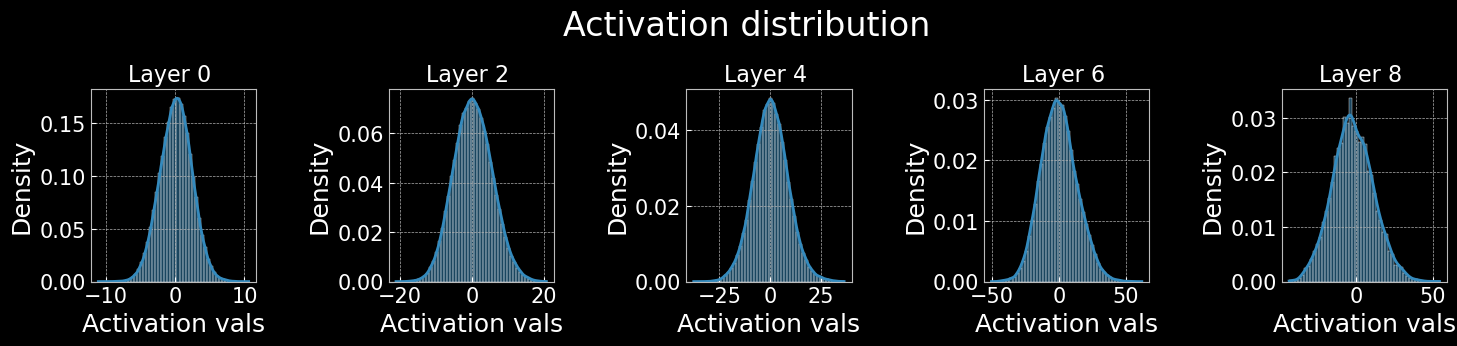

Layer 0 - Variance: 5.285141468048096
Layer 2 - Variance: 28.062334060668945
Layer 4 - Variance: 73.84526824951172
Layer 6 - Variance: 180.6513214111328
Layer 8 - Variance: 179.22607421875


In [18]:
var_init(model, std=0.1)
vis_gradients(model)
vis_activations(model, print_variance=True)

With a higher standard deviation, the activations are likely to explode. You can play around with the specific standard deviation values, but it will be hard to find one that gives us a good activation distribution across layers and is very specific to our model. 

If we would change the hidden sizes or number of layers, you would have to search all over again, which is neither efficient nor recommended.

# [3] Eq Var Init and How to Find Appropriate Init Values

We state two requirements:
1. The mean of the activations should be zero
2. The variance of the activations should stay the same across every layer

This requires the bias and weight to have an expectation of 0.
Thus, we should initialize the weight distribution with a variance of the inverse of the input dimension $d_x$. 

Note that our initialization does not restrict us to a normal distribution, but allows any other distribution with a mean of 0 and variance of $1/d_x$. You often see that a uniform distribution is used for initialization. A small benefit of using a uniform instead of a normal distribution is that we can exclude the chance of initializing very large or small weights.

In [25]:
for name, param in model.named_parameters():
    if not name.endswith(".bias"):
        cprint(param.shape)
        # break

# cprint(model)

<module> -> param.shape:
torch.Size([512, 784])
<module> -> param.shape:
torch.Size([256, 512])
<module> -> param.shape:
torch.Size([256, 256])
<module> -> param.shape:
torch.Size([128, 256])
<module> -> param.shape:
torch.Size([10, 128])


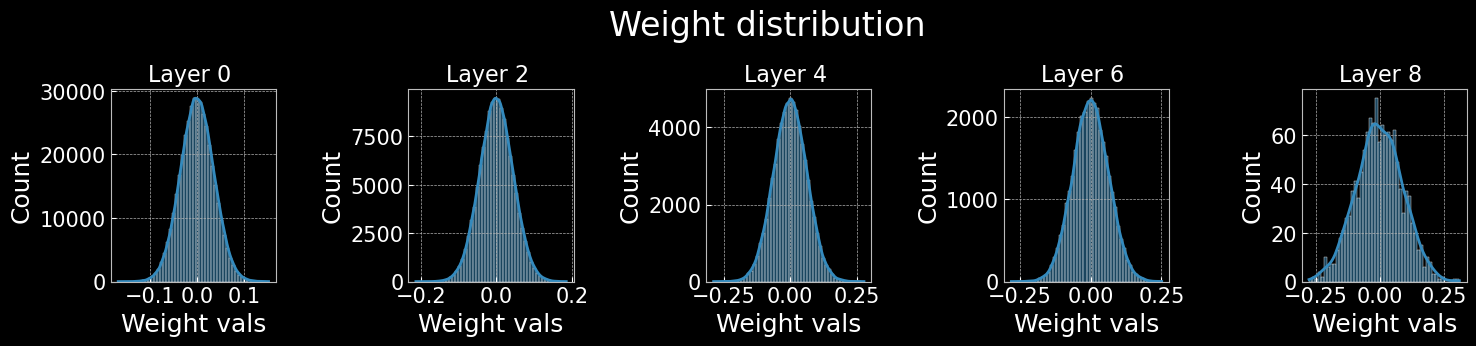

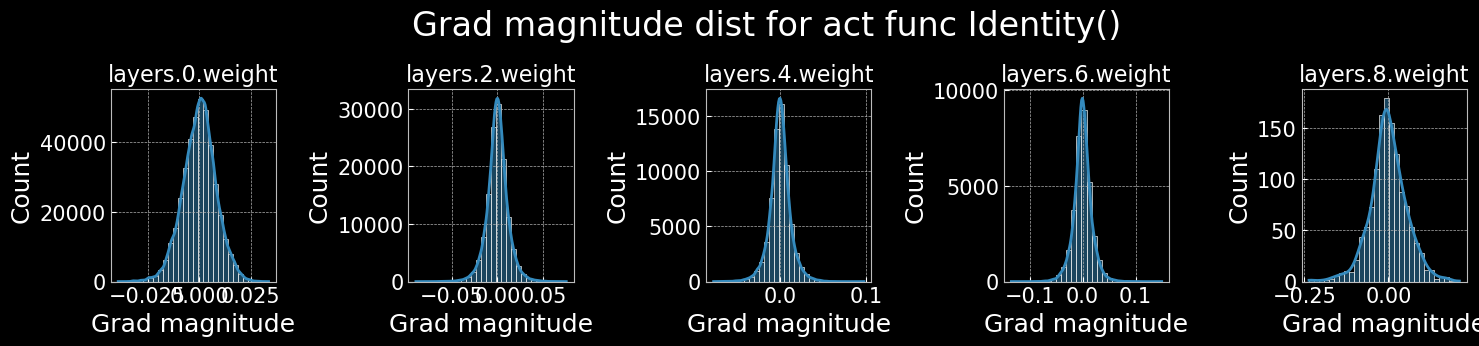

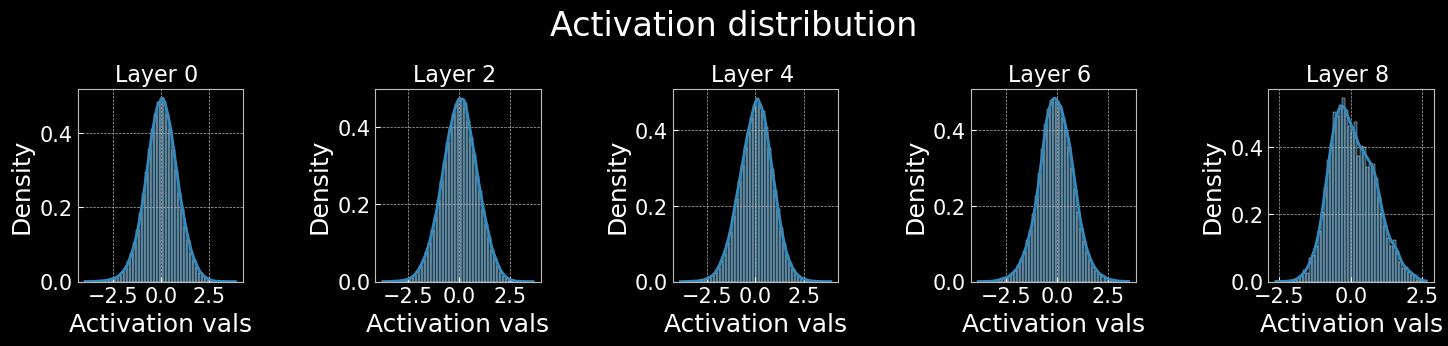

Layer 0 - Variance: 0.7125735282897949
Layer 2 - Variance: 0.7203376293182373
Layer 4 - Variance: 0.7348622679710388
Layer 6 - Variance: 0.7159548401832581
Layer 8 - Variance: 0.5824133157730103


In [19]:
def equal_var_init(model):
    for name, param in model.named_parameters():
        # fill bias with 0
        if name.endswith(".bias"):
            param.data.fill_(0)
        else:
            # nn.Linear's input dim is param.shape[1]
            param.data.normal_(std=1.0 / np.sqrt(param.shape[1]))

equal_var_init(model)
vis_weight_distribution(model)  # our focus is var init, weights is data.normal_
vis_gradients(model)
vis_activations(model, print_variance=True)

# [4] Xavier Init and Kaiming Init

$$W\sim \mathcal{N}\left(0,\frac{2}{d_x+d_y}\right)$$

If we use a uniform distribution, we would initialize the weights with:

$$W\sim U\left[-\frac{\sqrt{6}}{\sqrt{d_x+d_y}}, \frac{\sqrt{6}}{\sqrt{d_x+d_y}}\right]$$


## Xavier Init + no Act Fn

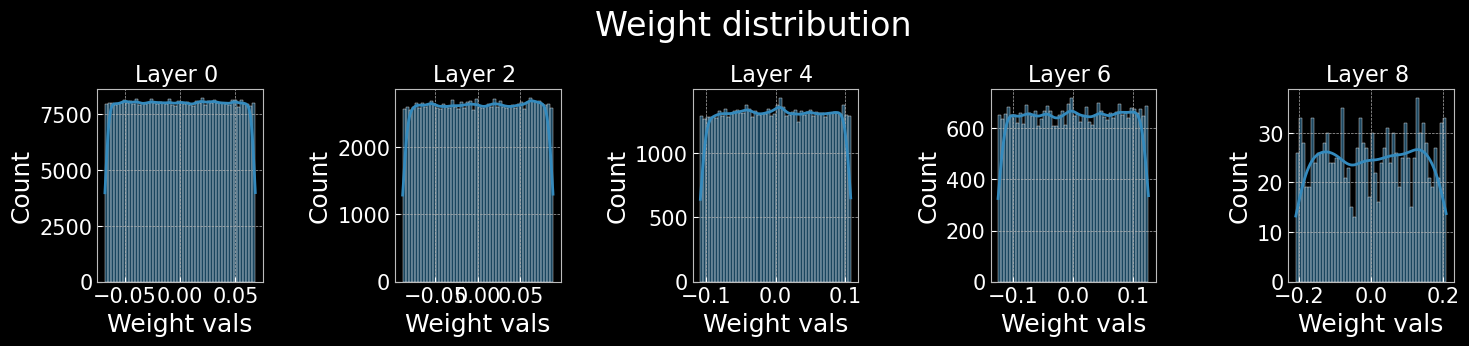

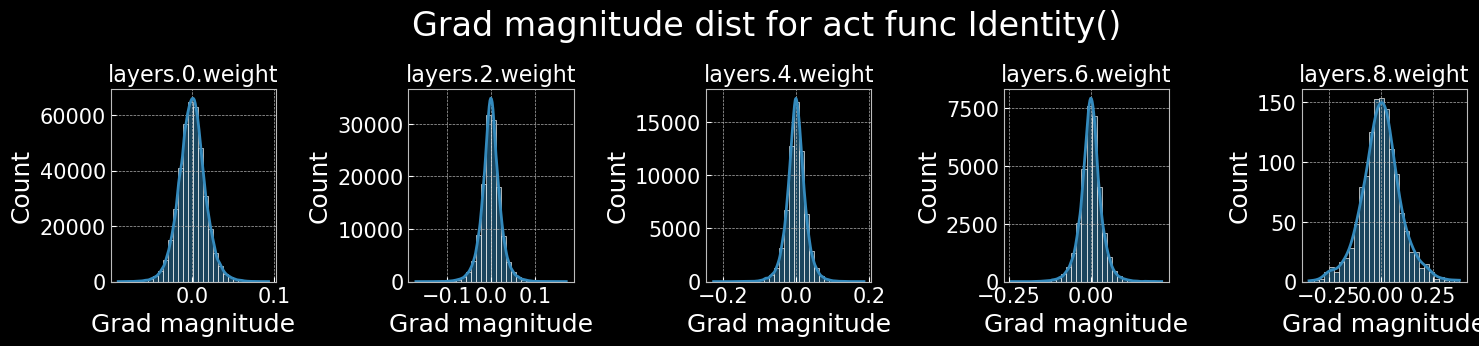

layers.0.weight - Variance: 0.0002721885102801025
layers.2.weight - Variance: 0.0004945634282194078
layers.4.weight - Variance: 0.0006957593723200262
layers.6.weight - Variance: 0.0010665825102478266
layers.8.weight - Variance: 0.009153196588158607


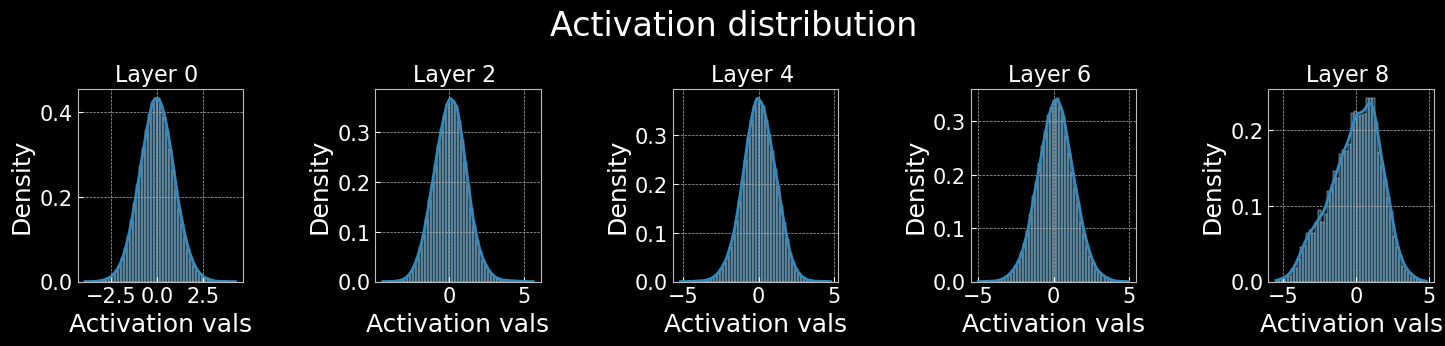

Layer 0 - Variance: 0.859072744846344
Layer 2 - Variance: 1.207491397857666
Layer 4 - Variance: 1.179962158203125
Layer 6 - Variance: 1.4306081533432007
Layer 8 - Variance: 2.9658780097961426


In [26]:
def xavier_init(model):
    for name, param in model.named_parameters():
        if name.endswith(".bias"):
            param.data.fill_(0)
        else:
            # dy = param.shape[0], dx = param.shape[1]
            bound = np.sqrt(6) / np.sqrt(param.shape[0] + param.shape[1])

            # https://pytorch.org/docs/stable/generated/torch.Tensor.uniform_.html
            param.data.uniform_(-bound, bound)
  
xavier_init(model)
vis_weight_distribution(model)  # this time weights is data.uniform_
vis_gradients(model, print_variance=True)
vis_activations(model, print_variance=True)

## Xavier Init + Tanh

We see that the Xavier initialization balances the variance of gradients and activations. Note that the significantly higher variance for the output layer is due to the large difference of input and output dimension ($128$ vs $10$). 

However, we currently assumed the activation function to be linear. So what happens if we add a non-linearity? In a tanh-based network, a common assumption is that for small values during the initial steps in training, the $\tanh$ works as a linear function such that we don't have to adjust our calculation. 

We can check if that is the case for us as well:

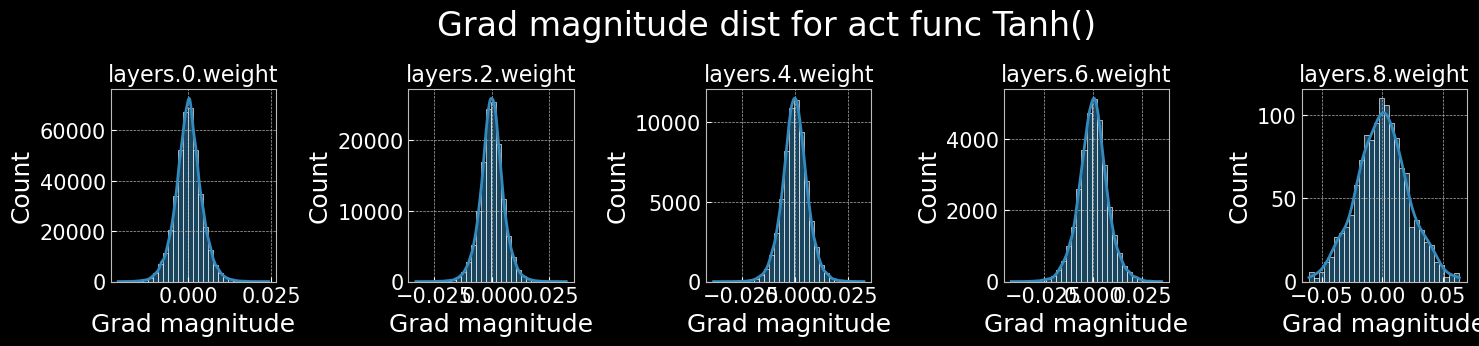

layers.0.weight - Variance: 1.610137042007409e-05
layers.2.weight - Variance: 2.600638981675729e-05
layers.4.weight - Variance: 3.5502926039043814e-05
layers.6.weight - Variance: 5.466334550874308e-05
layers.8.weight - Variance: 0.0004633499193005264


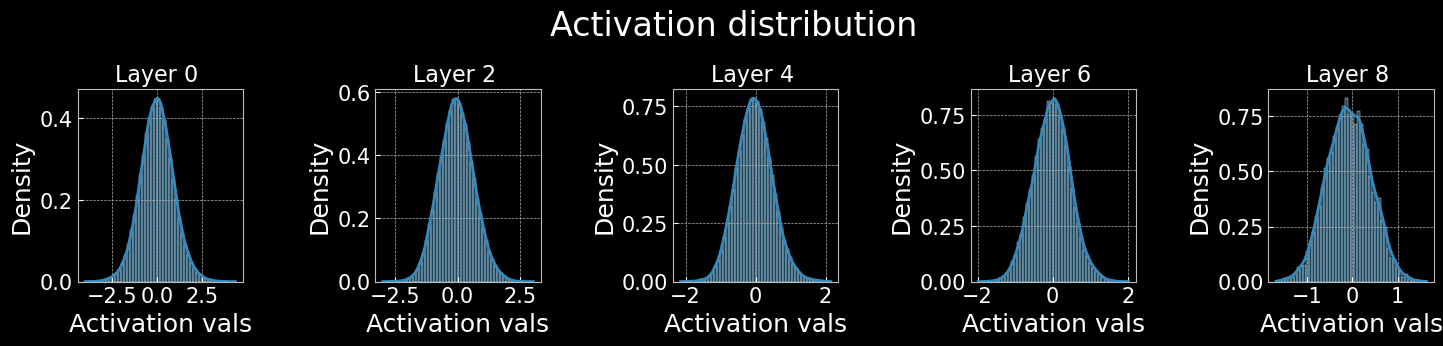

Layer 0 - Variance: 0.8464241027832031
Layer 2 - Variance: 0.48406240344047546
Layer 4 - Variance: 0.2630035877227783
Layer 6 - Variance: 0.23969121277332306
Layer 8 - Variance: 0.23282256722450256


In [29]:
model = BaseNN(act_fn=Tanh()).to(device)
xavier_init(model)
vis_gradients(model, print_variance=True)
vis_activations(model, print_variance=True)

Although the variance decreases over depth, it is apparent that the activation distribution becomes more focused on the low values. Therefore, our variance will stabilize around 0.25 if we would go even deeper.

## Kaiming Init + ReLU

We have an additional factor of 1/2 in the equation, so that our desired weight variance becomes $2/d_x$. This gives us the Kaiming initialization

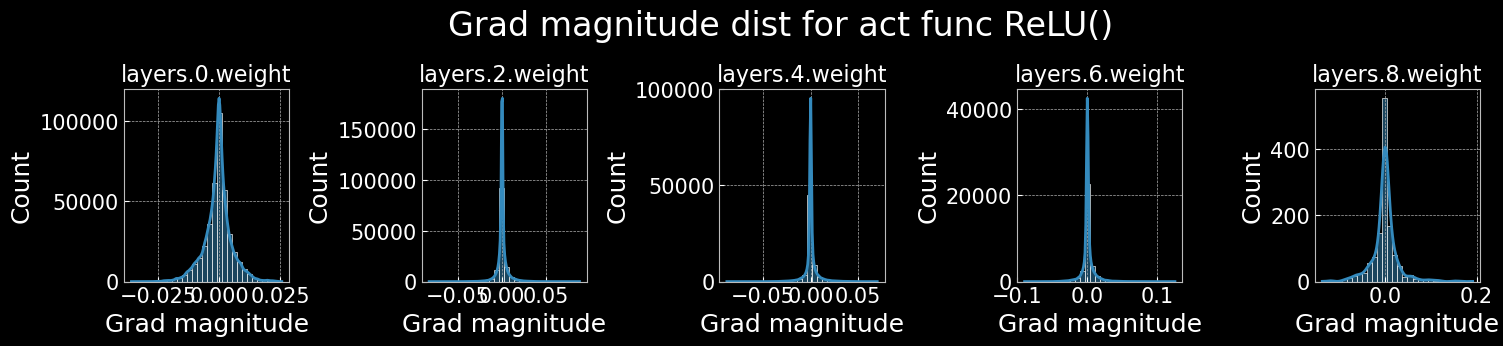

layers.0.weight - Variance: 3.165474845445715e-05
layers.2.weight - Variance: 3.874313915730454e-05
layers.4.weight - Variance: 4.461422940948978e-05
layers.6.weight - Variance: 8.128899935400113e-05
layers.8.weight - Variance: 0.0008449377492070198


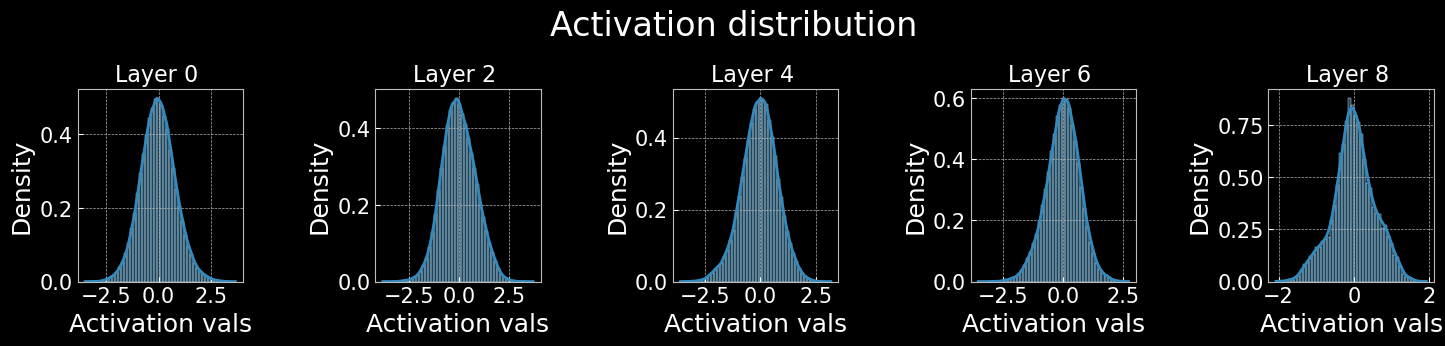

Layer 0 - Variance: 0.6865969896316528
Layer 2 - Variance: 0.7047713994979858
Layer 4 - Variance: 0.6445916891098022
Layer 6 - Variance: 0.4905802607536316
Layer 8 - Variance: 0.3146819472312927


In [30]:
def kaiming_init(model):
    for name, param in model.named_parameters():
        if name.endswith(".bias"):
            param.data.fill_(0)
        # The first layer does not have ReLU applied on its input
        elif name.startswith("layers.0"):
            param.data.normal_(0, 1 / np.sqrt(param.shape[1]))
        else:
            param.data.normal_(0, np.sqrt(2) / np.sqrt(param.shape[1]))

model = BaseNN(act_fn=ReLU()).to(device)
kaiming_init(model)
vis_gradients(model, print_variance=True)
vis_activations(model, print_variance=True)

https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.calculate_gain

The variance stays stable across layers. We can conclude that the Kaiming initialization indeed works well for ReLU-based networks. Note that for Leaky-ReLU etc., we have to slightly adjust the factor of $2$ in the variance as half of the values are not set to zero anymore. PyTorch provides a function to calculate this factor for many activation function, see `torch.nn.init.calculate_gain`